In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline
import sys
sys.path.append('..')
from meters.batch import MeterBatch
from meters.pipelines import PipelineFactory
from meters.dataset import Dataset, FilesIndex
import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet101, DenseNet121, VGG19, MobileNet_v2, TFModel

In [2]:
src = './../data/augment_data/images/'
fileindex = FilesIndex(path=src + '*.png', no_ext=True)
dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

# simple pred bb

In [3]:
pf = PipelineFactory()
src = '.'
batch_size = 10

config = {'model': MobileNet_v2,
          'model_name': 'model',
          'batch_size': batch_size, 
}

import tensorflow as tf
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

model_config = {
     'session' : {'config' : session_config},
     'body': {'width_factor' : 1},
     'inputs' : {'images': {'shape': B('image_shape'),
                            'data_format': 'channels_last'},
                 'labels': {'name': 'targets', 'shape' : (4,)}},
     'loss' : {'name' : 'huber', 'delta' : 1},
     'decay' : {'name':"exp", "decay_rate" : 0.95, 'learning_rate' : 1.,\
                "decay_steps" : 10, 'staircase' : True},
     'optimizer': {'name' : 'Momentum', 'momentum' : 0.99, 'use_nesterov' : True},
     'input_block/inputs' : 'images'}

In [4]:
ppl = pf.simple_predict_bb('model', './mobilenet_v2/', src='./../data/augment_data/', ppl_config=config)

In [5]:
ppl_pred_new = dset.train>>ppl
for i in tqn(range(100)):
    batch = ppl_pred_new.next_batch()
#     print(batch.labels)
#     plt.imshow(batch.images[0])
#     plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:tensorflow:Restoring parameters from ./mobilenet_v2/model-45950



# simple train bb

In [6]:
ppl = pf.simple_train_bb('./../data/augment_data/', ppl_config=config, model_config=model_config)

Widget Javascript not detected.  It may not be installed or enabled properly.


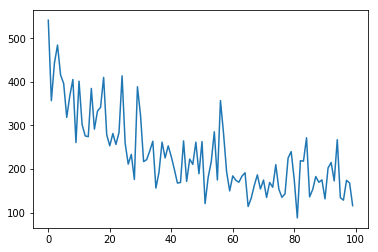

In [7]:
ppl_new = dset.train>>ppl
for i in tqn(range(100)):
    batch = ppl_new.next_batch()
plt.plot(ppl_new.get_variable('current_loss'))

# train digits on predicted bb

In [4]:
pf = PipelineFactory()
src = './../data/augment_data/'
images_src = './../data/outcomes_data/images/'
config = {
    'bbox_comp': 'coordinates',
    'model': VGG19,
    'model_name': VGG19,
    'batch_size': 5
}
ppl = pf.train_on_pred_bb(src, images_src, 'model', './mobilenet_v2/', (64, 32), ppl_config=config)

INFO:tensorflow:Restoring parameters from ./mobilenet_v2/model-45950



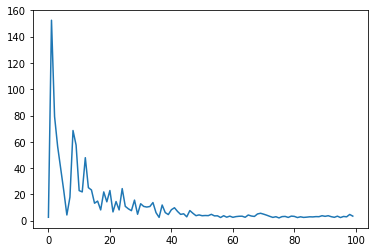

In [9]:
ppl_new = dset.train>>ppl
for i in tqn(range(100)):
    batch = ppl_new.next_batch()
plt.plot(ppl_new.get_variable('current_loss'))

# train on digits

In [5]:
train_ppl = pf.simple_train(src='./../data/outcomes_data/', 
                            shape=(64,32),
                            ppl_config={'model': VGG19,
                                        'model_name': 'digits',
                                        'batch_size': 1,
                                        'n_epochs': None})

Widget Javascript not detected.  It may not be installed or enabled properly.


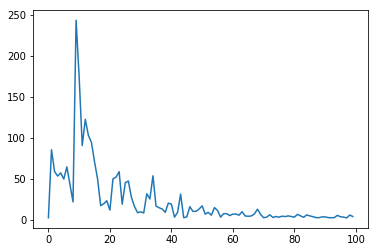

In [10]:
ppl_new = dset.train>>train_ppl
for i in tqn(range(100)):
    batch = ppl_new.next_batch()
plt.plot(ppl_new.get_variable('current_loss'))

# pred on digits

In [7]:
pred_ppl = pf.simple_predict('digits', ppl_new, shape=(64, 32), src='./../data/outcomes_data/')

In [8]:
ppl_new = dset.train>>pred_ppl
batch = ppl_new.next_batch()

In [10]:
ppl_new.get_variable('digits_prediction'), batch.labels

([array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)],
 array([0, 0, 1, 1, 9, 0, 5, 5]))

# pred digits on pred bb

In [9]:
ppl = pf.simple_predict_numbers('model', './mobilenet_v2/', 'digits', ppl_new, src='./../data/augment_data/', 
                                images_src='./../data/outcomes_data/images/', ppl_config_digits = {})

In [10]:
ppl_new = dset.train>>ppl
batch = ppl_new.next_batch()

INFO:tensorflow:Restoring parameters from ./mobilenet_v2/model-45950


In [11]:
ppl_new.get_variable('digits_prediction'), batch.labels

([array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)],
 array([0, 0, 0, 0, 2, 5, 1, 4]))